In [21]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
# return the mean value of non-normalized weights for loglikelihood estimation
# and the normalized weights for resampling step


def importance_ratio(likelihood_func, y, xs, eta):
    log_weights = np.zeros(len(xs))
    for i in range(len(xs)):
        log_weights[i] = likelihood_func(y, xs[i], eta[i])
    maximum = np.max(log_weights)
    weights_ratio = np.exp(log_weights - maximum)
    likelihood = np.mean(weights_ratio) * np.exp(maximum)
    normalized_weights = weights_ratio / sum(weights_ratio)
    return likelihood, normalized_weights

# resampling methods


def continuous_stratified_resample(weights, xs):
    n = len(weights)
    # generate n uniform rvs with stratified method
    u0 = np.random.uniform(size=1)
    u = [(u0 + i) / n for i in range(n)]
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    for i in range(1, n):
        pi[i] = (weights[i] + weights[i - 1]) / 2
    # pi = np.append(0, weights)
    # algo described in the paper A.3.

    r = np.zeros(n)
    u_new = np.zeros(n)
    s = 0
    j = 1

    for i in range(n + 1):
        s = s + pi[i]
        while(j <= n and u[j - 1] <= s):
            r[j - 1] = i
            u_new[j - 1] = (u[j - 1] - (s - pi[i])) / pi[i]
            j = j + 1
    r = r.astype(int)
    x_new = np.zeros(n)
    for k in range(n):
        if r[k] == 0:
            x_new[k] = xs[0]
        elif r[k] == n:
            x_new[k] = xs[-1]
        else:
            x_new[k] = (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
    return x_new


def particle_filter(observations, initial_particles, likelihood_func, transition, N, seed=1234):
    np.random.seed(seed=seed)
    T = len(observations)
    u = np.zeros(T)
    quantiles = np.zeros((T,5))
    likelihoods = np.zeros(T)
    eta_t = np.random.randn(N)
    for i in range(T):
        quantiles[i] = np.percentile(np.exp(initial_particles/2),[5,25,50,75,95])
        # u_t calculation
        u[i] = np.mean(norm.cdf(observations[i]*np.exp(-initial_particles/2)))
        initial_particles = np.sort(initial_particles)
        likelihood, normalized_weights = importance_ratio(
            likelihood_func, observations[i], initial_particles, eta_t)
        likelihoods[i] = likelihood
        # print(likelihood)
        new_particles = continuous_stratified_resample(
            normalized_weights, initial_particles)

        eta_t = np.random.randn(N)
        for j in range(N):
            initial_particles[j] = transition(
                new_particles[j], eta_t[j])
        # print(len(np.unique(new_particles)), len(np.unique(initial_particles)))
        # print('time step {} finished with likelihood {}'.format(i, likelihood))
    return likelihoods,u,quantiles



def generator_sv_with_leverage(mu=0.5, phi=0.975, sigma_eta_square=0.02, rho=-0.8, T=1000, seed=2345):
    np.random.seed(seed=seed)
    x = 0
    ys = np.zeros(T)
    ys[0] = np.random.randn(1) * np.exp(x / 2)
    for i in range(1,T):
        eta_t = np.random.randn(1)
        epsilon_t = rho * eta_t + np.sqrt(1 - rho**2) * np.random.randn(1)
        x = mu * (1 - phi) + phi * x + np.sqrt(sigma_eta_square) * eta_t
        ys[i] = epsilon_t * np.exp(x / 2)
        
        # ys[i] = rho * np.exp(x / 2) * eta_t + np.random.randn(1) * \
        #     np.sqrt((1 - rho ** 2) * np.exp(x))
        

    print('sample generated with success !')
    return ys

# generate initial particles with stationary distribution if it exists


def initial_particle(N):
    return np.random.randn(N)

# likelihood function


def likelihood_function(y, x, eta):
    return norm.logpdf(y, loc=rho*np.exp(x/2)*eta, scale=np.sqrt(1-rho**2)*np.exp(x / 2))

# transition function


def transition_sample(x, eta):
    return mu * (1 - phi) + phi * x + np.sqrt(sigma_eta_square) * eta


# mus = [i * 0.02 for i in range(8,18)]
# mus = [i*0.02 for i in range(5,15)]
# S&P 500 Historical data
# parameters
# mu = 0.1717
# phi = 0.9832
# sigma_eta_square = 0.0218
# rho = 0
# print(rho)
# # # parameters
mu = 0.2432
phi = 0.9739
sigma_eta_square = 0.0307
# rho = -0.7944
# rho = 0
# print(rho)

T = 2000
N = 500

# plt.plot(observations)
# plt.show()

sp = pd.read_csv('data/S&P 500 Historical Data.csv')
sp = sp.set_index('Date')
sp.index = pd.to_datetime(sp.index)
close_price = np.asarray(sp['19950515':'20030424']['Close'])

dr2000 = (close_price[1:] - close_price[:2000]) / close_price[:2000]

iteration 10
[-3044.07183215]
[-0.2  0.   0.   0.   0.   0.   0.   0.   0.   0. ]


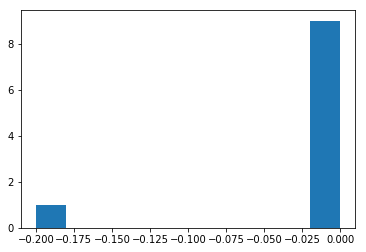

In [11]:
## 10 iterations for multiple rho values
#rhos = [-0.1*i for i in range(9)]
rhos = [-0.2]
cumulated_likelihoods = np.zeros((10,len(rhos)))
estimations = np.zeros(10)
Us = []
Quantiles = []
np.random.seed(seed=1234)
for seed in range(10,11):
    print('iteration {}'.format(seed))
    initial_particles = initial_particle(N=N)
    loglikelihoods = np.zeros(len(rhos))
    for k in range(len(rhos)):
        rho = rhos[k]
        likelihoods,u, quantiles = particle_filter(observations=observations, initial_particles=initial_particles,
                                      likelihood_func=likelihood_function, transition=transition_sample, N=N,seed=seed)
        loglikelihood = sum(np.log(likelihoods))
        loglikelihoods[k] = loglikelihood
        Us.append(u)
        Quantiles.append(quantiles)
        # print(
        #     'log-likelihood calculation finished for mu = {} : {}'.format(mu, loglikelihood))
    print(loglikelihoods)
    # plt.plot(mus, loglikelihoods)
    # plt.show()
    estimations[seed-10] = rhos[np.argmax(loglikelihoods)]
    cumulated_likelihoods[seed-10,:] = loglikelihoods
print(estimations)
plt.hist(estimations)
plt.show()

In [13]:
Quantiles[0]

array([[ 0.45679187,  0.74341429,  1.01839928,  1.34619339,  2.17947463],
       [ 0.3460888 ,  0.59681672,  0.8117843 ,  1.11852337,  1.73269204],
       [ 0.31328359,  0.49880685,  0.68884348,  0.89118072,  1.47135588],
       ..., 
       [ 0.79906575,  1.01011589,  1.2119771 ,  1.41551154,  1.7735317 ],
       [ 0.91944238,  1.14830688,  1.33872386,  1.53014202,  1.84965864],
       [ 0.88408773,  1.09235679,  1.29307619,  1.49528112,  1.84690981]])

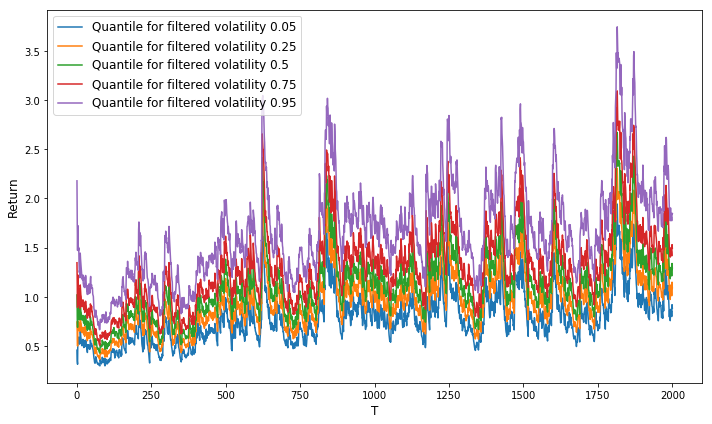

In [19]:
Qs = [0.05, 0.25, 0.5, 0.75, 0.95]
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(np.arange(1, len(dr2000)+1), Quantiles[0][:, i], label='Quantile for filtered volatility {}'.format(Qs[i]))
plt.xlabel('T', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('image/sv_quantile_sp2.png')
plt.show()

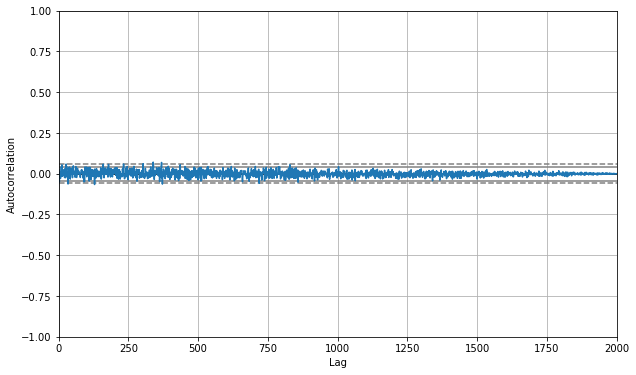

In [23]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
s = autocorrelation_plot(Us[0])
plt.savefig('image/acf_rho2.png')

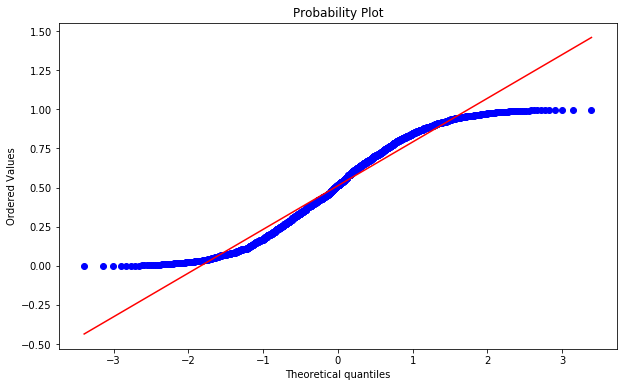

In [22]:
plt.figure(figsize=(10, 6))
res = stats.probplot(Us[0], plot=plt)
plt.show()